In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import norm, t, multivariate_normal, binom, bernoulli

In [142]:
power = 0.8
alpha = 0.02
effect_size = 0.05

In [143]:
def get_sample_size(power=0.8, alpha=0.05, effect_size=0.2):
    
    # calculate the z-score (# of std dev from mean) for 
    # desired significance level
    z_alpha = norm.ppf(1-alpha/2)
    
    # calculate the z-score for the desired power
    z_beta = norm.ppf(power)
    
    # calculate the required sample size
    n = 2 * (z_alpha + z_beta)**2 / effect_size**2
    
    return int(np.ceil(n))

In [152]:
def get_sample_size_risk_ratio(power=0.8, alpha=0.05, control_group=0.5, treatment_group=0.3):
    
    z_alpha = norm.ppf(1-alpha/2)
    z_beta = norm.ppf(power)
    
    p1 = control_group
    p2 = treatment_group
    relative_risk_reduction = (p1 - p2) / p1
    
    # calculating sample size
    n = ((z_alpha + z_beta) ** 2)  * (2 * p1 * (1 - p1)) / ((p1-p2)) ** 2
    
    return int(np.ceil(n))

In [154]:
get_sample_size_risk_ratio(power, alpha, control_group=0.012, treatment_group=0.0098)

49169

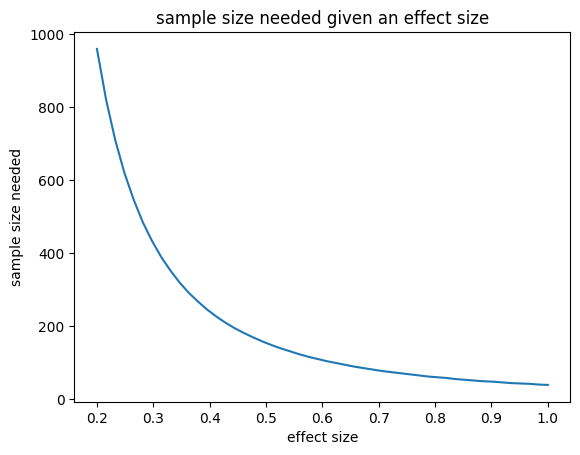

In [27]:
effect_sizes = np.linspace(0.2, 1, 50)
powers = np.linspace(0.5, 1)

fig, ax = plt.subplots()

plt.plot(effect_sizes,
         [get_sample_size(power=power, alpha=alpha, effect_size=x) for x in effect_sizes]
        )

ax.set_xlabel("effect size")
ax.set_ylabel("sample size needed")
ax.set_title("sample size needed given an effect size")

plt.show()

In [81]:
def calculate_cohens_d(x: list[float], y: list[float]) -> None:
    "a simple function to calculate cohen's d"
    
    sx, sy = len(x), len(y)
    
    x_mean, y_mean = np.mean(x), np.mean(y)
    x_var, y_var = np.var(x, ddof=1), np.var(y, ddof=1)
    
    pooled_var = ((sx-1) * x_var + (sy-1) * y_var) / (sx + sy - 1)
    
    return (x_mean - y_mean) / np.sqrt(pooled_var)

In [82]:
sample_one = norm.rvs(2.5, 12, 65)
sample_two = norm.rvs(2.05, 5.5, 1000)

calculate_cohens_d(sample_one, sample_two)

-0.21599857536582132

In [76]:
# manually calculating the covariance of two arrays
means = [2, 14]
covariances = [[1, 0.2], [0.2, 1]]

# getting random values from a multivariate normal
a, b = multivariate_normal.rvs(means, covariances, 10000).T

# calculating the mean of each array
a_mean, b_mean = np.mean(a), np.mean(b)

# calculating diff between each value and its array mean
a_dev, b_dev = a - a_mean, b - b_mean

# calculating the dot product of devations from group means
dot_prod = np.dot(a_dev, b_dev)

# dividing the dot product by the smallest sample
# and subtracting one (degree of freedom)
calculated_cov = dot_prod / (min(len(a), len(b)) - 1)

In [121]:
def get_samples(mean: float, sd: float, samples:int, size:int) -> None:
    
    mean = mean
    std = sd
    
    results = []
    
    for i in range(samples):
        
        sample_ = norm.rvs(mean, sd, size)
        means_ = np.mean(sample_)
        results.append(means_)

    
    fig, ax = plt.subplots()
    
    plt.hist(np.array(results), bins=10)
    
    plt.show()

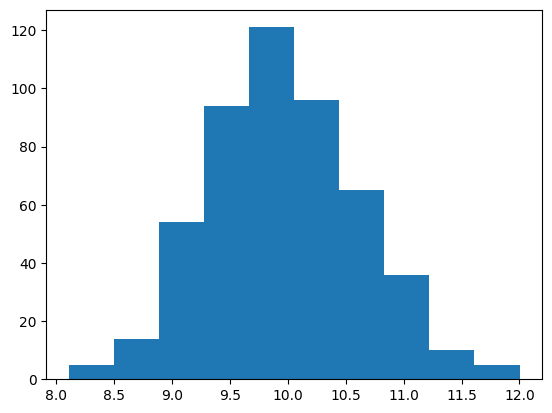

In [124]:
get_samples(10, 15, 500, 500)

In [116]:
def plot_confidence_interval(sample: list[float], confidence: float = 0.95) -> None:
    
    
    sample_mean = np.mean(sample)
    sample_std = np.std(sample)
    sample_standard_error = sample_std / np.sqrt(len(sample))
    
    critical_value = norm.ppf(1 - ((1 - confidence) / 2))
    
    lower_bound = sample_mean - critical_value * sample_standard_error
    upper_bound = sample_mean + critical_value * sample_standard_error
    
    # the bell curve
    mu, sigma = sample_mean, sample_standard_error
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*(x-mu)**2/sigma**2)
    
    # plot the curve
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y, ax=ax)
    
    ax.fill_between(x, y, where=(x>=lower_bound) & (x<=upper_bound), alpha=0.3, color='blue')
    
    ax.axvline(sample_mean, linestyle='--', color='red', label='sample_mean')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('distribution of expected population means given sample')

    plt.show()
    
    print('standard error:', sigma)

In [125]:
sample = norm.rvs(10, 15, 500)

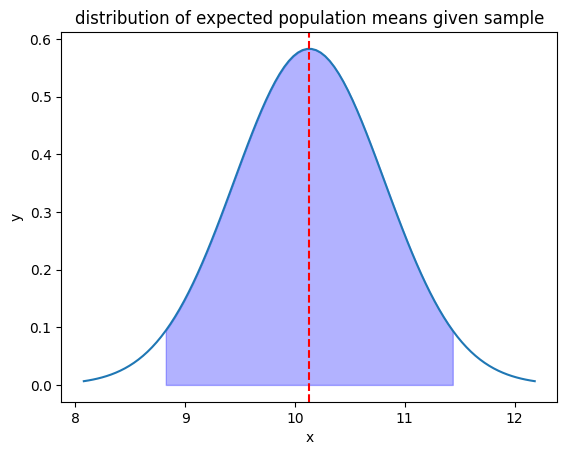

standard error: 0.6842711569482883


In [126]:
plot_confidence_interval(sample)

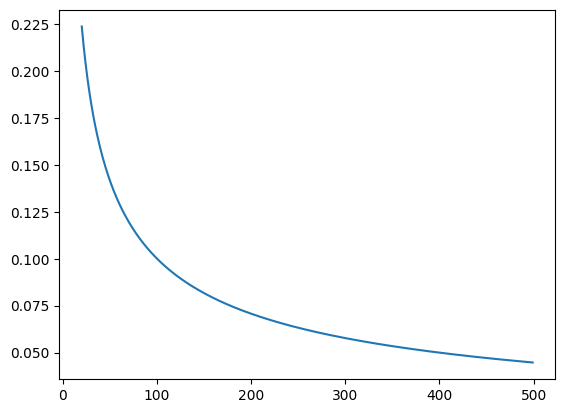

In [139]:
sample_std = 1

std_errors = [sample_std / np.sqrt(x) for x in range(20, 500)]

plt.plot(range(20, 500), std_errors)

In [155]:
# calculating the standard error for a binary outcome, e.g. mortality 
probability = 0.15
sample_size = 35000

standard_error = np.sqrt(probability*(1-probability)/sample_size)
print(standard_error)

0.0019086270308410554


In [189]:
def standard_error_risk_ratio(treatment=None, control=None):
    
    sample_size_treatment = len(treatment)
    yes_treatment = np.sum(treatment)
    no_treatment = sample_size_treatment - yes_treatment
    
    
    sample_size_control = len(control)
    yes_control = np.sum(control)
    no_control = sample_size_control - yes_control
    
    treatment_risk = yes_treatment / sample_size_treatment
    control_risk = yes_control / sample_size_control
    
    risk_ratio = treatment_risk / control_risk
    
    standard_error_risk = (
        np.sqrt((1 / yes_treatment) + (1 / yes_treatment) - (1 / sample_size_treatment) - (1 / sample_size_control))
    )  
    
    return risk_ratio

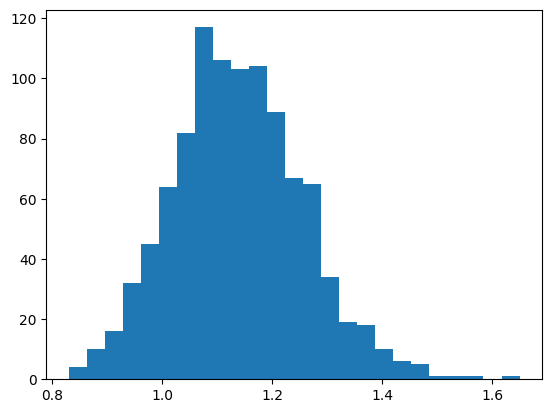

In [191]:
ses = []

for i in range(1000):
    x = bernoulli.rvs(0.44, size=250)
    y = bernoulli.rvs(0.39, size=250)

    se = standard_error_risk_ratio(x, y)
    ses.append(se)
    
plt.hist(ses, bins=25)

plt.show()